# How to Use Riveter 💪

This Jupyter notebook will demonstrate how to use the Riveter package to measure social dynamics between personas mentioned in a collection of texts.

The package identifies and extracts the subjects, verbs, and direct objects in texts; it performs coreference resolution on the personas mentioned in the texts (e.g., clustering "Elizabeth Bennet", "Lizzy," and "she" together as one persona); and it measures social dynamics between the personas by referencing a given lexicon. The package currently includes Maarten Sap et al's lexicon for power and agency and Rashkin et al's lexicon for perspective, effect, value, and mental state. 

## Import Libraries

In [1]:
import os
import random
from riveter import Riveter

## Demo with Sap et al's Power and Agency Lexicon

Here are three example stories that we will use to measure power and agency between personas:
> 1. I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.

> 2. My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.

> 3. She went to the store. She thanked the doctor.

In [2]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.",
                   "She went to the store. She thanked the doctor."]
text_ids = [0, 1, 2]

## Load Lexicon ("Power") and Train Model

In [3]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(example_stories,
              text_ids)

100%|██████████| 3/3 [00:00<00:00, 32.67it/s]

2023-02-24 07:50:31 Complete!


## Get Total Scores for All Documents

You can use the `.get_score_totals()` function to get cumulative power scores (or chosen dynamic scores) for each persona mentioned in the texts.

In [4]:
riveter.get_score_totals(frequency_threshold=2)

{'i': -0.3333333333333333, 'my doctor': 1.0, 'my friend': 0.5, 'susan': -0.5}

You can also see what words or names have been clustered together for each persona (performed by the coreference resolution model).

In [5]:
riveter.get_persona_cluster('my doctor')

{'my doctor': 2, 'him': 1, 'the doctor': 1}

In [6]:
riveter.get_persona_cluster('susan')

{'susan': 1, 'she': 1}

In [7]:
riveter.get_persona_cluster('i')

{'i': 5, 'me': 1}

## Plot Scores for All Documents

You can use the `.plot_scores()` function to display a bar plot with the top *n* or bottom *n* personas in the texts. The function will display the top 10 highest-scoring personas by default.

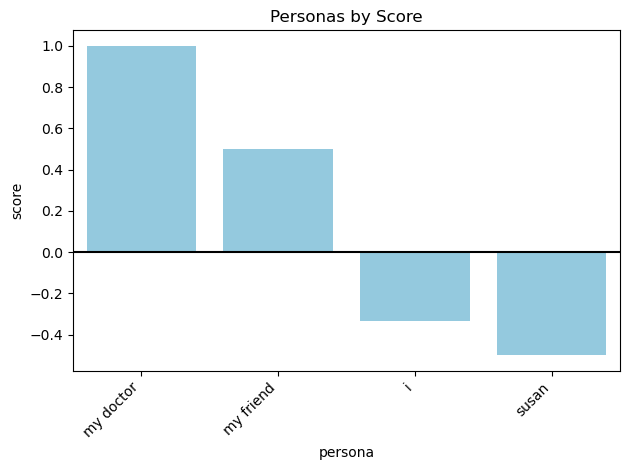

In [8]:
riveter.plot_scores(frequency_threshold=2)

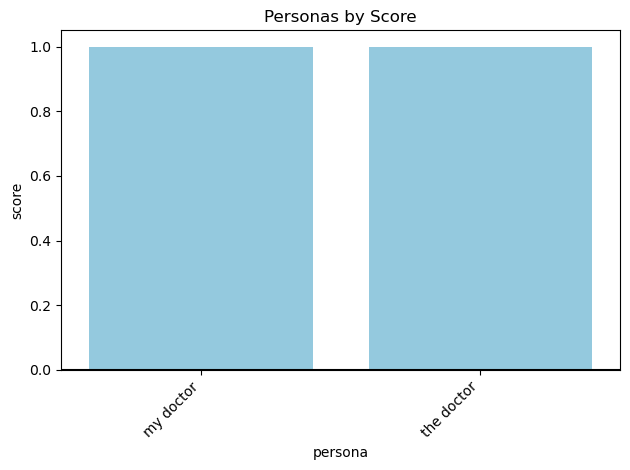

In [9]:
riveter.plot_scores(2)

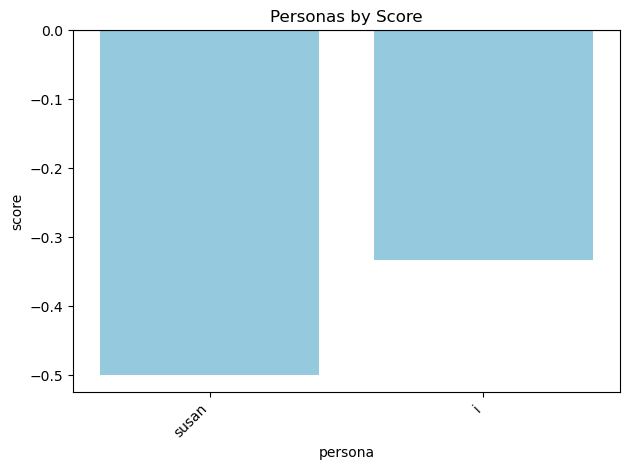

In [10]:
riveter.plot_scores(-2)

## Get Scores, Subjects, and Direct Objects for Each Document

You can use the `.get_score_for_doc()` function to get power scores (or chosen dynamic scores) for each persona mentioned in a document (based on the document id passed into the training function).

In [11]:
example_stories[0]

'I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.'

In [12]:
riveter.get_scores_for_doc(0)

{'i': -0.2, 'my doctor': 1.0, 'my friend': 0.5}

You can use `.count_nsubj_for_doc()` to get all noun subjects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [13]:
riveter.count_nsubj_for_doc(0)

{('i', 'think'): 1,
 ('i', 'have'): 1,
 ('i', 'feel'): 1,
 ('i', 'call'): 1,
 ('my friend', 'be'): 1}

You can use `.count_dobj_for_doc()` to get all direct objects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [14]:
riveter.count_dobj_for_doc(0)

{('my doctor', 'call'): 1, ('my friend', 'call'): 1, ('i', 'pick'): 1}

## Plot Scores for Each Document

You can use the `.plot_scores_for_doc()` function to display a bar plot with the top *n* or bottom *n* personas in a specified document. The function will display the top 10 highest-scoring personas by default.

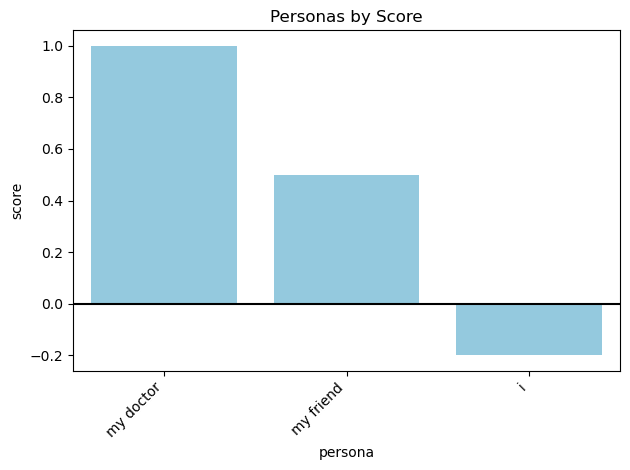

In [15]:
riveter.plot_scores_for_doc(0)

## Regular Expression 

In [16]:
riveter.train(example_stories,
              text_ids,
              persona_patterns_dict={'first person singular': r'^i$|^me$'})

100%|██████████| 3/3 [00:00<00:00, 43.01it/s]

2023-02-24 07:50:48 Complete!


In [17]:
riveter.get_score_totals()

{'first person singular': -0.3333333333333333}

In [18]:
riveter = Riveter()
riveter.load_sap_lexicon('agency')
riveter.train(example_stories,
              text_ids)

100%|██████████| 3/3 [00:00<00:00, 41.54it/s]

2023-02-24 07:50:49 Complete!


In [19]:
riveter.get_score_totals()

{'i': 0.3333333333333333,
 'my friend': 0.0,
 'my doctor': 0.25,
 'susan': 0.5,
 'the doctor': 0.0}

<br><br><br><br>

# **Small demo w/ Rashkin frames**

In [20]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too."]
text_ids = [0, 1]

In [21]:
riveter = Riveter()
riveter.load_rashkin_lexicon('effect')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 31.65it/s]

2023-02-24 07:50:52 Complete!


In [22]:
riveter.get_score_totals()

{'i': 0.34444444444450006,
 'my doctor': 0.35,
 'my friend': 0.1333333333335,
 'susan': 0.16666666666649999}

In [23]:
riveter.get_scores_for_doc(0)

{'i': 0.28, 'my doctor': 0.266666666667, 'my friend': 0.1333333333335}

In [24]:
riveter.get_scores_for_doc(1)

{'susan': 0.16666666666649999,
 'my doctor': 0.3777777777776667,
 'i': 0.666666666667}

In [25]:
riveter = Riveter()
riveter.load_rashkin_lexicon('value')
riveter.train(example_stories,
              text_ids)

100%|██████████| 2/2 [00:00<00:00, 31.95it/s]

2023-02-24 07:50:57 Complete!


In [26]:
riveter.get_score_totals()

{'i': 0.6444444444445,
 'my friend': 0.4333333333335,
 'my doctor': 0.8000000000002501,
 'susan': 0.5333333333335}

<br><br><br><br>

# **Bigger demo w/ Sap frames and example dataset**

In [23]:
texts = []
text_ids = []
stories_path = '/Users/maria/Documents/data/narrativity/litbank/original'   # Litbank corpus here: https://github.com/dbamman/litbank

j = 0
for _file_name in os.listdir(stories_path):
    _lines = []
    for _line in open(stories_path + '/' + _file_name, 'r'):
        if _line.strip():
            _lines.append(_line.strip())

    # Randomly sample 100 paragraphs from each book
    for _line in random.sample(_lines, 100):        
        texts.append(_line)
        text_ids.append(j)
        j += 1

len(texts), len(text_ids)

(10000, 10000)

In [24]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
             text_ids)

100%|██████████| 10000/10000 [01:37<00:00, 102.04it/s]

2023-02-24 07:48:54 Complete!


In [25]:
riveter.save('/Users/maria/Desktop/riveter.litbank.pkl')

Riveter successfully saved to "/Users/maria/Desktop/riveter.litbank.pkl"


In [51]:
persona_score_dict = riveter.get_score_totals(frequency_threshold=0)
len(persona_score_dict)

1097

In [52]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(_score, '\t', _persona)

1.0 	 the cautious old gentleman
1.0 	 her beautiful hair
1.0 	 her refusal
1.0 	 morpheus
1.0 	 mr. wilson
1.0 	 captain smollett
1.0 	 george merry
1.0 	 silver
1.0 	 joyce
1.0 	 artist
1.0 	 they embroider slippers
1.0 	 her fair friend
1.0 	 her play
1.0 	 the young woman
1.0 	 the little dramatic student
1.0 	 her kindness
1.0 	 devil
1.0 	 esau
1.0 	 mr. craven
1.0 	 those children


In [53]:
# The scores above are skewed by infrequent entities.
# For example, an entity could appear just once in the dataset, and if it has power in that one instance, it will have a score of 1.0.
# We can remove the infrequent entities to clean up the ranked list.
# (Note that this wasn't a great test dataset because most entities don't occur very often; hopefully the NYT data is better!)

persona_score_dict = riveter.get_score_totals(frequency_threshold=5)
len(persona_score_dict)

134

In [54]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 2), '\t', _persona)

0.8 	 anthony
0.6 	 fred
0.57 	 sam
0.56 	 her mother
0.5 	 the old woman
0.5 	 lord henry
0.5 	 a lady
0.43 	 carol
0.4 	 no man
0.4 	 lady
0.4 	 the professor
0.4 	 the happy family
0.38 	 florence
0.36 	 the old man
0.35 	 dick
0.33 	 isabella
0.33 	 jim
0.33 	 frank
0.33 	 miss marjoribanks
0.33 	 zora
0.3 	 katharine
0.27 	 god
0.27 	 her father
0.25 	 nancy
0.25 	 daisy
0.22 	 jane
0.22 	 "i
0.2 	 strether
0.2 	 people
0.2 	 a wife
0.2 	 my aunt
0.2 	 sir
0.2 	 her name
0.2 	 edward
0.2 	 "you
0.2 	 alphonse
0.2 	 it
0.2 	 my boy
0.2 	 alice
0.19 	 winterbourne
0.17 	 wife
0.17 	 the captain
0.17 	 roy
0.17 	 his father
0.17 	 paul
0.17 	 the girl
0.15 	 tommy
0.14 	 the doctor
0.14 	 the young man
0.14 	 lucilla
0.14 	 halsey
0.14 	 your
0.13 	 anne
0.13 	 man
0.12 	 her husband
0.12 	 the woman
0.12 	 mrs. medlock
0.12 	 " he
0.12 	 tuppence
0.12 	 friend
0.11 	 yourself
0.1 	 you
0.1 	 jo
0.1 	 i
0.1 	 tom
0.09 	 the lady
0.08 	 the man
0.08 	 helen
0.07 	 a woman
0.04 	 mary


In [55]:
riveter.get_persona_cluster('mary')

{'mary': 18, 'me': 1, 'she': 2, 'herself': 1, 'her': 2, 'him': 1}

In [56]:
riveter.get_persona_cluster('you')

{'you': 914,
 'i': 60,
 'yours': 3,
 'he': 2,
 'me': 12,
 'ye': 1,
 'her': 2,
 'she': 3,
 'yourself': 3}

In [57]:
riveter.get_persona_cluster('the man')

{'the man': 35, 'i': 1}

In [58]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
             text_ids,
             persona_patterns_dict={'masculine pronouns': r'^he$|^him$|^himself$',
                                    'feminine pronouns': r'^she$|^her$|^herself$',
                                    'third person plural pronouns': r'^they$|^them$|^themselves$'})

100%|██████████| 10000/10000 [01:32<00:00, 108.46it/s]

2023-02-24 07:44:02 Complete!


In [59]:
persona_score_dict = riveter.get_score_totals()
len(persona_score_dict)

3

In [60]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 3), '\t', _persona)

0.114 	 masculine pronouns
0.096 	 feminine pronouns
0.082 	 third person plural pronouns


In [61]:
riveter.get_persona_cluster('masculine pronouns')

{'he': 1451, 'him': 322, 'himself': 57}

In [62]:
riveter.get_persona_cluster('feminine pronouns')

{'her': 226, 'she': 919, 'herself': 40}

In [63]:
riveter.get_persona_cluster('third person plural pronouns')

{'they': 396, 'them': 146, 'themselves': 21}